# Домашнее задание №3

## 1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * ## Сгенерировать настоящие данные
 * ## Изменить архитектуру дискриминатора и генератора
 * ## Без графиков домашку не принимаю

## Подключение библиотек и настройка среды

In [60]:
import numpy as np
import os
import math

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid
import matplotlib.patches as mpatches

In [61]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
torch.manual_seed(111)

cuda


## Получение данных для обучения

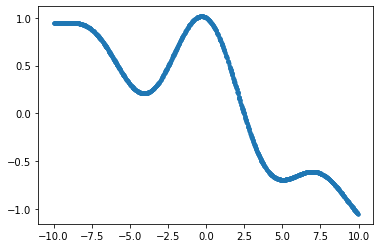

In [62]:
min_x = -10
max_x = 10
train_data_length = 2048
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = (max_x - min_x) * torch.rand(train_data_length) + min_x
train_data[:, 1] = torch.sin(train_data[:, 0])/train_data[:, 0] - train_data[:, 0]/10
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
plt.plot(train_data[:, 0], train_data[:, 1], ".")

## Описание и создание генератора и дискриминатора

In [63]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

In [64]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2))

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

## Задание гиперпараметров обучения и загрузчика

In [65]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [66]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [67]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

## Обучение модели

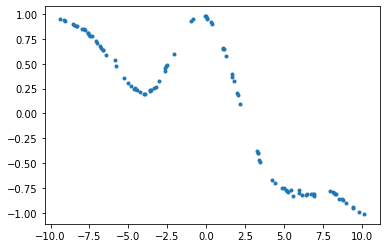

Epoch: 290 Loss D.: 0.6818199753761292
Epoch: 290 Loss G.: 0.6722296476364136


In [68]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

d_loss_history = []
g_loss_history = []

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        if epoch % 10 == 0 and n == batch_size - 1:
          # Выводим 100 точек из восстановленного распределения через каждые 10 эпох
          display.clear_output(wait=False)
          latent_space_samples = torch.randn(100, 2)
          generated_samples = generator(latent_space_samples)
          generated_samples = generated_samples.detach()
          plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
          plt.show()
          # Выводим и сохраняем значения функций потерь
          print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
          print(f"Epoch: {epoch} Loss G.: {loss_generator}")
          d_loss_history.append(loss_discriminator)
          g_loss_history.append(loss_generator)

## Вывод полученных результатов

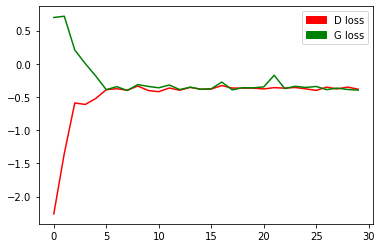

In [69]:
plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend(handles=[red_patch, green_patch])

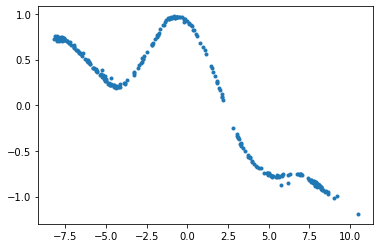

In [70]:
latent_space_samples = torch.randn(300, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

## 2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [71]:
n_epochs = 10
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [72]:
# Класс, чтобы делать reshape в Sequential как в Keras
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [73]:
# 1-й вариант генератора
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        

        self.model = nn.Sequential(
            nn.Linear(100, 256*7*7),
            #nn.ReLU(),
            View((-1, 256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Tanh()
        )


    def forward(self, z):
        return self.model(z)

In [74]:
# 2-й вариант генератора
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        

        self.model = nn.Sequential(
            nn.Linear(100, 256*7*7),
            #nn.ReLU(),
            View((-1, 256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1,  output_padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Tanh()
        )


    def forward(self, z):
        return self.model(z)


In [75]:
# Проверяем генератор
G = Generator()
z = torch.rand(100)
img = G(z)
img.shape

torch.Size([1, 1, 28, 28])

In [76]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),

            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),

            nn.Dropout2d(0.25),
            nn.ZeroPad2d((0, 1, 0, 1)),      # Паддинг до четного числа высоты и ширины изображения
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 0),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),

            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
  
    def forward(self, img):
        return self.model(img)

In [77]:
# Проверяем дискриминатор
D = Discriminator()
prob = D(img)
prob

tensor([[0.4883]], grad_fn=<SigmoidBackward>)

In [78]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

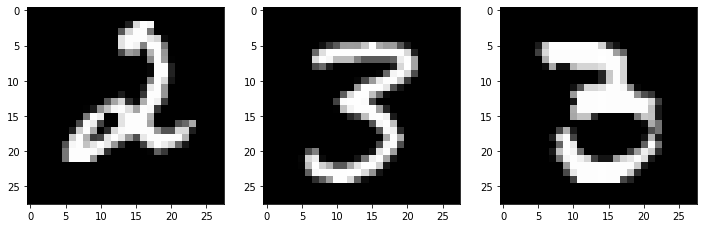

In [79]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [80]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [81]:
d_loss_history = []
g_loss_history = []

In [82]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/10] [Batch 933/938] [D loss: 0.480960] [G loss: 1.544416]


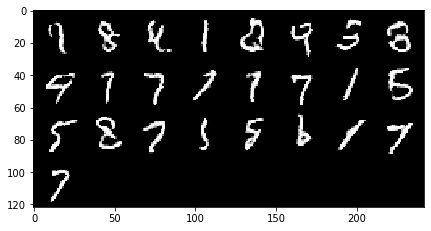

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

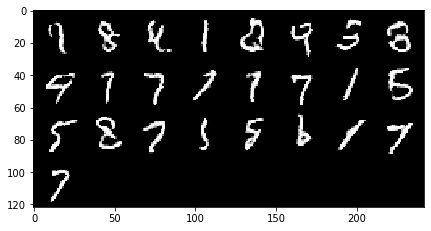

In [83]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            # Вывод сгенерированной картинки
            sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            #plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            #plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            #plt.legend(handles=[red_patch, green_patch])
            #plt.show()

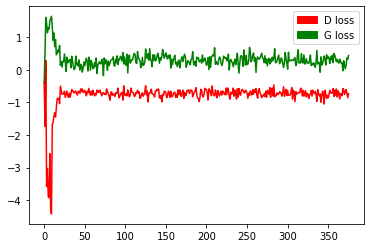

In [84]:
plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend(handles=[red_patch, green_patch])

## Источники

https://proglib.io/p/generativno-sostyazatelnaya-neyroset-vasha-pervaya-gan-model-na-pytorch-2020-08-11

https://www.kaggle.com/tjac718/dcgan-on-mnist-dataset-using-pytorch